# Bayesian Workflow Demo: Complete NLSQ → NUTS → ArviZ Pipeline

This notebook demonstrates the recommended three-stage Bayesian workflow:
1. **Stage 1**: NLSQ point estimation (fast, ~seconds)
2. **Stage 2**: NUTS posterior sampling with warm-start (~minutes)
3. **Stage 3**: ArviZ diagnostic plots (visual verification)

**Expected runtime**: ~30 seconds (depending on hardware)

**Requirements**:
- rheojax with Bayesian dependencies (numpyro, arviz)
- matplotlib for visualization

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from rheojax.models import Maxwell

from rheojax.core.jax_config import safe_import_jax

# Safe JAX import (ensures float64 precision)
jax, jnp = safe_import_jax()

print("="*70)
print("BAYESIAN WORKFLOW DEMONSTRATION")
print("="*70)
print("\nThis demo shows the recommended NLSQ → NUTS → ArviZ workflow")
print("for uncertainty quantification in rheological modeling.\n")

BAYESIAN WORKFLOW DEMONSTRATION

This demo shows the recommended NLSQ → NUTS → ArviZ workflow
for uncertainty quantification in rheological modeling.



## Step 1: Generate Synthetic Relaxation Data

We'll create synthetic Maxwell relaxation data with realistic noise to demonstrate the workflow.

In [3]:
print("Step 1: Generating synthetic Maxwell relaxation data...")
print("-"*70)

# True parameters
G0_true = 1e5  # Pa
eta_true = 1e3  # Pa·s
tau_true = eta_true / G0_true  # 0.01 s

print(f"  True parameters:")
print(f"    G₀  = {G0_true:.2e} Pa")
print(f"    η   = {eta_true:.2e} Pa·s")
print(f"    τ   = {tau_true:.4f} s")

# Time array (log-spaced for relaxation)
t = np.logspace(-2, 2, 50)  # 0.01 to 100 seconds

# True relaxation modulus
G_t_true = G0_true * np.exp(-t / tau_true)

# Add realistic noise (1.5% relative)
np.random.seed(42)
noise_level = 0.015
noise = np.random.normal(0, noise_level * G_t_true)
G_t_noisy = G_t_true + noise

print(f"\n  Generated {len(t)} data points from {t.min():.2e} to {t.max():.1f} s")
print(f"  Noise level: {noise_level*100:.1f}% relative")
print(f"  Signal-to-noise ratio: {np.mean(G_t_true)/np.std(noise):.1f}")

Step 1: Generating synthetic Maxwell relaxation data...
----------------------------------------------------------------------
  True parameters:
    G₀  = 1.00e+05 Pa
    η   = 1.00e+03 Pa·s
    τ   = 0.0100 s

  Generated 50 data points from 1.00e-02 to 100.0 s
  Noise level: 1.5% relative
  Signal-to-noise ratio: 36.0


## Stage 1: NLSQ Point Estimation (Fast)

First, we obtain fast point estimates using nonlinear least squares optimization.

In [4]:
print("\n" + "="*70)
print("STAGE 1: NLSQ POINT ESTIMATION")
print("="*70)

model = Maxwell()
model.parameters.set_bounds('G0', (1e3, 1e7))
model.parameters.set_bounds('eta', (1e1, 1e5))

print("\nRunning NLSQ optimization...")
import time

start_nlsq = time.time()

model.fit(t, G_t_noisy, method='nlsq')

nlsq_time = time.time() - start_nlsq

# Extract NLSQ results
G0_nlsq = model.parameters.get_value('G0')
eta_nlsq = model.parameters.get_value('eta')
tau_nlsq = eta_nlsq / G0_nlsq

print(f"\n✓ NLSQ completed in {nlsq_time:.3f} seconds")
print(f"\nNLSQ Point Estimates:")
print(f"  G₀  = {G0_nlsq:.4e} Pa  (error: {abs(G0_nlsq-G0_true)/G0_true*100:.2f}%)")
print(f"  η   = {eta_nlsq:.4e} Pa·s  (error: {abs(eta_nlsq-eta_true)/eta_true*100:.2f}%)")
print(f"  τ   = {tau_nlsq:.6f} s  (error: {abs(tau_nlsq-tau_true)/tau_true*100:.2f}%)")
print(f"\n⚠  Note: NLSQ provides point estimates only (no uncertainty)")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06



STAGE 1: NLSQ POINT ESTIMATION

Running NLSQ optimization...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.290236s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=0.0014 | elapsed=1.290s | final_gradient_norm=9.8301e-05



✓ NLSQ completed in 1.730 seconds

NLSQ Point Estimates:
  G₀  = 1.0053e+05 Pa  (error: 0.53%)
  η   = 1.0044e+03 Pa·s  (error: 0.44%)
  τ   = 0.009992 s  (error: 0.08%)

⚠  Note: NLSQ provides point estimates only (no uncertainty)


## Stage 2: Bayesian Inference with Warm-Start

Now we perform MCMC sampling using NUTS, warm-starting from the NLSQ estimates for faster convergence.

In [5]:
print("\n" + "="*70)
print("STAGE 2: BAYESIAN INFERENCE (NUTS)")
print("="*70)

print("\nRunning NUTS sampling with NLSQ warm-start...")
print("  Configuration:")
print(f"    • num_chains: 4 (for robust diagnostics)")
print(f"    • num_warmup: 1000 (burn-in iterations)")
print(f"    • num_samples: 2000 (posterior samples per chain)")
print(f"    • warm-start: Yes (from NLSQ estimates)")
print("\n  This may take 20-60 seconds depending on your hardware...")

start_bayes = time.time()

# Run Bayesian inference with warm-start
result = model.fit_bayesian(
    t, G_t_noisy,
    num_warmup=1000,
    num_samples=2000,
    num_chains=4,
    initial_values={  # Warm-start from NLSQ
        'G0': G0_nlsq,
        'eta': eta_nlsq
    }
)

bayes_time = time.time() - start_bayes

print(f"\n✓ Bayesian inference completed in {bayes_time:.1f} seconds")
print(f"  Total time (NLSQ + Bayes): {nlsq_time + bayes_time:.1f} seconds")
print(f"  Generated {result.num_chains * result.num_samples} posterior samples")


STAGE 2: BAYESIAN INFERENCE (NUTS)

Running NUTS sampling with NLSQ warm-start...
  Configuration:
    • num_chains: 4 (for robust diagnostics)
    • num_warmup: 1000 (burn-in iterations)
    • num_samples: 2000 (posterior samples per chain)
    • warm-start: Yes (from NLSQ estimates)

  This may take 20-60 seconds depending on your hardware...


  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:01<1:01:01,  1.22s/it]

warmup:   0%|          | 2/3000 [00:02<55:25,  1.11s/it]  

warmup:   1%|          | 22/3000 [00:02<03:20, 14.88it/s]

warmup:   1%|▏         | 38/3000 [00:02<01:45, 27.96it/s]

warmup:   2%|▏         | 55/3000 [00:02<01:07, 43.95it/s]

warmup:   2%|▏         | 69/3000 [00:02<00:51, 56.66it/s]

warmup:   3%|▎         | 82/3000 [00:02<00:42, 68.21it/s]

warmup:   3%|▎         | 97/3000 [00:02<00:35, 82.46it/s]

warmup:   4%|▎         | 111/3000 [00:03<00:36, 80.24it/s]

warmup:   4%|▍         | 123/3000 [00:03<00:33, 86.51it/s]

warmup:   4%|▍         | 135/3000 [00:03<00:31, 90.76it/s]

warmup:   5%|▍         | 148/3000 [00:03<00:29, 98.29it/s]

warmup:   5%|▌         | 160/3000 [00:03<00:28, 100.03it/s]

warmup:   6%|▌         | 180/3000 [00:03<00:22, 125.45it/s]

warmup:   7%|▋         | 204/3000 [00:03<00:17, 155.94it/s]

warmup:   8%|▊         | 234/3000 [00:03<00:14, 193.10it/s]

warmup:   9%|▊         | 258/3000 [00:03<00:13, 202.32it/s]

warmup:   9%|▉         | 281/3000 [00:04<00:12, 209.17it/s]

warmup:  10%|█         | 314/3000 [00:04<00:11, 242.44it/s]

warmup:  12%|█▏        | 354/3000 [00:04<00:09, 286.79it/s]

warmup:  13%|█▎        | 392/3000 [00:04<00:08, 304.69it/s]

warmup:  14%|█▍        | 423/3000 [00:04<00:08, 290.67it/s]

warmup:  15%|█▌        | 461/3000 [00:04<00:08, 312.65it/s]

warmup:  17%|█▋        | 503/3000 [00:04<00:07, 340.99it/s]

warmup:  18%|█▊        | 552/3000 [00:04<00:06, 381.34it/s]

warmup:  20%|█▉        | 591/3000 [00:04<00:06, 358.33it/s]

warmup:  21%|██        | 628/3000 [00:05<00:06, 356.24it/s]

warmup:  22%|██▏       | 664/3000 [00:05<00:06, 346.18it/s]

warmup:  23%|██▎       | 701/3000 [00:05<00:06, 350.33it/s]

warmup:  25%|██▍       | 737/3000 [00:05<00:07, 323.22it/s]

warmup:  26%|██▌       | 774/3000 [00:05<00:06, 335.70it/s]

warmup:  27%|██▋       | 809/3000 [00:05<00:06, 328.71it/s]

warmup:  28%|██▊       | 843/3000 [00:05<00:07, 292.85it/s]

warmup:  29%|██▉       | 874/3000 [00:05<00:07, 289.48it/s]

warmup:  30%|███       | 914/3000 [00:05<00:06, 318.04it/s]

warmup:  32%|███▏      | 963/3000 [00:06<00:05, 359.94it/s]

warmup:  33%|███▎      | 1000/3000 [00:06<00:05, 348.19it/s]

sample:  35%|███▌      | 1055/3000 [00:06<00:04, 401.00it/s]

sample:  37%|███▋      | 1096/3000 [00:06<00:05, 378.84it/s]

sample:  38%|███▊      | 1137/3000 [00:06<00:04, 386.25it/s]

sample:  39%|███▉      | 1181/3000 [00:06<00:04, 400.80it/s]

sample:  41%|████      | 1222/3000 [00:06<00:04, 375.45it/s]

sample:  42%|████▏     | 1264/3000 [00:06<00:04, 387.06it/s]

sample:  43%|████▎     | 1304/3000 [00:06<00:04, 375.12it/s]

sample:  45%|████▍     | 1342/3000 [00:07<00:04, 361.88it/s]

sample:  46%|████▌     | 1379/3000 [00:07<00:04, 340.62it/s]

sample:  47%|████▋     | 1419/3000 [00:07<00:04, 355.43it/s]

sample:  48%|████▊     | 1455/3000 [00:07<00:04, 355.93it/s]

sample:  50%|████▉     | 1491/3000 [00:07<00:04, 302.57it/s]

sample:  51%|█████     | 1527/3000 [00:07<00:04, 316.36it/s]

sample:  52%|█████▏    | 1561/3000 [00:07<00:04, 322.65it/s]

sample:  53%|█████▎    | 1597/3000 [00:07<00:04, 331.77it/s]

sample:  54%|█████▍    | 1631/3000 [00:07<00:04, 320.54it/s]

sample:  55%|█████▌    | 1664/3000 [00:08<00:04, 320.52it/s]

sample:  57%|█████▋    | 1700/3000 [00:08<00:03, 330.81it/s]

sample:  58%|█████▊    | 1743/3000 [00:08<00:03, 355.66it/s]

sample:  59%|█████▉    | 1783/3000 [00:08<00:03, 368.16it/s]

sample:  61%|██████    | 1821/3000 [00:08<00:03, 365.17it/s]

sample:  62%|██████▏   | 1858/3000 [00:08<00:03, 359.99it/s]

sample:  63%|██████▎   | 1901/3000 [00:08<00:02, 377.38it/s]

sample:  65%|██████▍   | 1939/3000 [00:08<00:02, 363.49it/s]

sample:  66%|██████▌   | 1977/3000 [00:08<00:02, 366.62it/s]

sample:  67%|██████▋   | 2014/3000 [00:08<00:02, 362.41it/s]

sample:  68%|██████▊   | 2051/3000 [00:09<00:02, 358.12it/s]

sample:  70%|██████▉   | 2087/3000 [00:09<00:02, 344.72it/s]

sample:  71%|███████   | 2125/3000 [00:09<00:02, 352.57it/s]

sample:  72%|███████▏  | 2164/3000 [00:09<00:02, 361.09it/s]

sample:  73%|███████▎  | 2204/3000 [00:09<00:02, 371.62it/s]

sample:  75%|███████▍  | 2246/3000 [00:09<00:01, 382.84it/s]

sample:  76%|███████▌  | 2285/3000 [00:09<00:01, 369.75it/s]

sample:  77%|███████▋  | 2323/3000 [00:09<00:01, 361.27it/s]

sample:  79%|███████▉  | 2370/3000 [00:09<00:01, 390.54it/s]

sample:  80%|████████  | 2410/3000 [00:10<00:01, 381.07it/s]

sample:  82%|████████▏ | 2449/3000 [00:10<00:01, 362.04it/s]

sample:  83%|████████▎ | 2486/3000 [00:10<00:01, 355.86it/s]

sample:  84%|████████▍ | 2522/3000 [00:10<00:01, 356.89it/s]

sample:  85%|████████▌ | 2558/3000 [00:10<00:01, 322.12it/s]

sample:  86%|████████▋ | 2591/3000 [00:10<00:01, 313.83it/s]

sample:  87%|████████▋ | 2624/3000 [00:10<00:01, 311.88it/s]

sample:  89%|████████▉ | 2664/3000 [00:10<00:01, 329.45it/s]

sample:  90%|████████▉ | 2698/3000 [00:10<00:00, 332.19it/s]

sample:  92%|█████████▏| 2752/3000 [00:11<00:00, 385.84it/s]

sample:  93%|█████████▎| 2791/3000 [00:11<00:00, 383.46it/s]

sample:  94%|█████████▍| 2830/3000 [00:11<00:00, 358.48it/s]

sample:  96%|█████████▌| 2874/3000 [00:11<00:00, 380.79it/s]

sample:  97%|█████████▋| 2913/3000 [00:11<00:00, 360.61it/s]

sample:  98%|█████████▊| 2950/3000 [00:11<00:00, 360.72it/s]

sample: 100%|█████████▉| 2989/3000 [00:11<00:00, 367.35it/s]

sample: 100%|██████████| 3000/3000 [00:11<00:00, 255.91it/s]


✓ Bayesian inference completed in 13.8 seconds
  Total time (NLSQ + Bayes): 15.5 seconds
  Generated 8000 posterior samples


## Posterior Results

Extract and display the posterior summary statistics and credible intervals.

In [6]:
print("\n" + "="*70)
print("POSTERIOR RESULTS")
print("="*70)

posterior = result.posterior_samples
summary = result.summary

print("\nPosterior Estimates (mean ± std):")
print(f"  G₀  = {summary['G0']['mean']:.4e} ± {summary['G0']['std']:.4e} Pa")
print(f"  η   = {summary['eta']['mean']:.4e} ± {summary['eta']['std']:.4e} Pa·s")

# Compute credible intervals
intervals = model.get_credible_intervals(posterior, credibility=0.95)
print("\n95% Credible Intervals:")
print(f"  G₀:  [{intervals['G0'][0]:.4e}, {intervals['G0'][1]:.4e}] Pa")
print(f"  η:   [{intervals['eta'][0]:.4e}, {intervals['eta'][1]:.4e}] Pa·s")

print("\nInterpretation:")
print("  'There is 95% probability that G₀ lies in the interval above'")
print("  This is a DIRECT probabilistic statement (Bayesian interpretation)")

# Relative uncertainties
print("\nRelative Uncertainties:")
print(f"  G₀:  {summary['G0']['std']/summary['G0']['mean']*100:.2f}%")
print(f"  η:   {summary['eta']['std']/summary['eta']['mean']*100:.2f}%")

# Check if true values are in credible intervals
G0_in_CI = intervals['G0'][0] <= G0_true <= intervals['G0'][1]
eta_in_CI = intervals['eta'][0] <= eta_true <= intervals['eta'][1]
print("\nValidation (true values in 95% CI):")
print(f"  G₀:  {'✓ Yes' if G0_in_CI else '✗ No'}")
print(f"  η:   {'✓ Yes' if eta_in_CI else '✗ No'}")


POSTERIOR RESULTS

Posterior Estimates (mean ± std):
  G₀  = 1.0022e+05 ± 3.7553e+02 Pa
  η   = 1.0052e+03 ± 1.3651e+00 Pa·s

95% Credible Intervals:
  G₀:  [9.9493e+04, 1.0098e+05] Pa
  η:   [1.0026e+03, 1.0079e+03] Pa·s

Interpretation:
  'There is 95% probability that G₀ lies in the interval above'
  This is a DIRECT probabilistic statement (Bayesian interpretation)

Relative Uncertainties:
  G₀:  0.37%
  η:   0.14%

Validation (true values in 95% CI):
  G₀:  ✓ Yes
  η:   ✗ No


## Stage 3: Convergence Diagnostics (CRITICAL!)

**Always check convergence before interpreting Bayesian results!**

We examine:
- **R-hat (Gelman-Rubin)**: Should be < 1.01 for all parameters
- **ESS (Effective Sample Size)**: Should be > 400 for reliable inference
- **Divergences**: Should be < 1% of total samples

In [7]:
print("\n" + "="*70)
print("STAGE 3: CONVERGENCE DIAGNOSTICS")
print("="*70)

diagnostics = result.diagnostics

print("\n⚠  ALWAYS check convergence before interpreting Bayesian results!")
print("\n1. R-hat (Gelman-Rubin Statistic):")
print(f"   Target: < 1.01 for all parameters")
for param in ['G0', 'eta']:
    rhat = diagnostics['r_hat'][param]
    status = '✓ Converged' if rhat < 1.01 else '✗ NOT converged'
    print(f"     {param:<5} R-hat = {rhat:.4f}  {status}")

print("\n2. ESS (Effective Sample Size):")
print(f"   Target: > 400 (out of {result.num_chains * result.num_samples} total)")
for param in ['G0', 'eta']:
    ess = diagnostics['ess'][param]
    efficiency = ess / (result.num_chains * result.num_samples) * 100
    status = '✓ Sufficient' if ess > 400 else '✗ Low (increase samples)'
    print(f"     {param:<5} ESS = {ess:.0f} ({efficiency:.1f}% efficient)  {status}")

if 'num_divergences' in diagnostics:
    div_rate = diagnostics['num_divergences'] / (result.num_chains * result.num_samples) * 100
    print("\n3. Divergences:")
    print(f"   Count: {diagnostics['num_divergences']} ({div_rate:.2f}%)")
    status = '✓ Good' if div_rate < 1 else '✗ High (results unreliable)'
    print(f"   Target: < 1%  {status}")

# Overall convergence assessment
all_converged = (
    all(diagnostics['r_hat'][p] < 1.01 for p in ['G0', 'eta']) and
    all(diagnostics['ess'][p] > 400 for p in ['G0', 'eta'])
)

print("\n" + "-"*70)
if all_converged:
    print("✓✓✓ EXCELLENT CONVERGENCE ✓✓✓")
    print("All diagnostic criteria met. Results are reliable.")
else:
    print("⚠⚠⚠ CONVERGENCE ISSUES ⚠⚠⚠")
    print("Increase num_warmup or num_samples and rerun.")
print("-"*70)


STAGE 3: CONVERGENCE DIAGNOSTICS

⚠  ALWAYS check convergence before interpreting Bayesian results!

1. R-hat (Gelman-Rubin Statistic):
   Target: < 1.01 for all parameters
     G0    R-hat = 1.0000  ✓ Converged
     eta   R-hat = 1.0000  ✓ Converged

2. ESS (Effective Sample Size):
   Target: > 400 (out of 8000 total)
     G0    ESS = 8000 (100.0% efficient)  ✓ Sufficient
     eta   ESS = 8000 (100.0% efficient)  ✓ Sufficient

----------------------------------------------------------------------
✓✓✓ EXCELLENT CONVERGENCE ✓✓✓
All diagnostic criteria met. Results are reliable.
----------------------------------------------------------------------


## Visual Diagnostics (ArviZ Integration)

ArviZ provides comprehensive diagnostic visualizations. We'll generate 6 key plots:

1. **Trace plot**: Visual convergence check
2. **Rank plot**: Most sensitive convergence test
3. **Pair plot**: Parameter correlations + divergences
4. **Autocorrelation plot**: Mixing quality
5. **ESS plot**: Sampling efficiency
6. **Forest plot**: Credible interval comparison

In [8]:
print("\n" + "="*70)
print("VISUAL DIAGNOSTICS (ArviZ Integration)")
print("="*70)

print("\nGenerating diagnostic plots...")

# Convert to ArviZ InferenceData
import arviz as az

idata = result.to_inference_data()


VISUAL DIAGNOSTICS (ArviZ Integration)

Generating diagnostic plots...



  [1/6] Trace plot - Visual convergence check
        • Left: Marginal posteriors (should overlap for all chains)
        • Right: Parameter evolution ('fuzzy caterpillar', no trends)


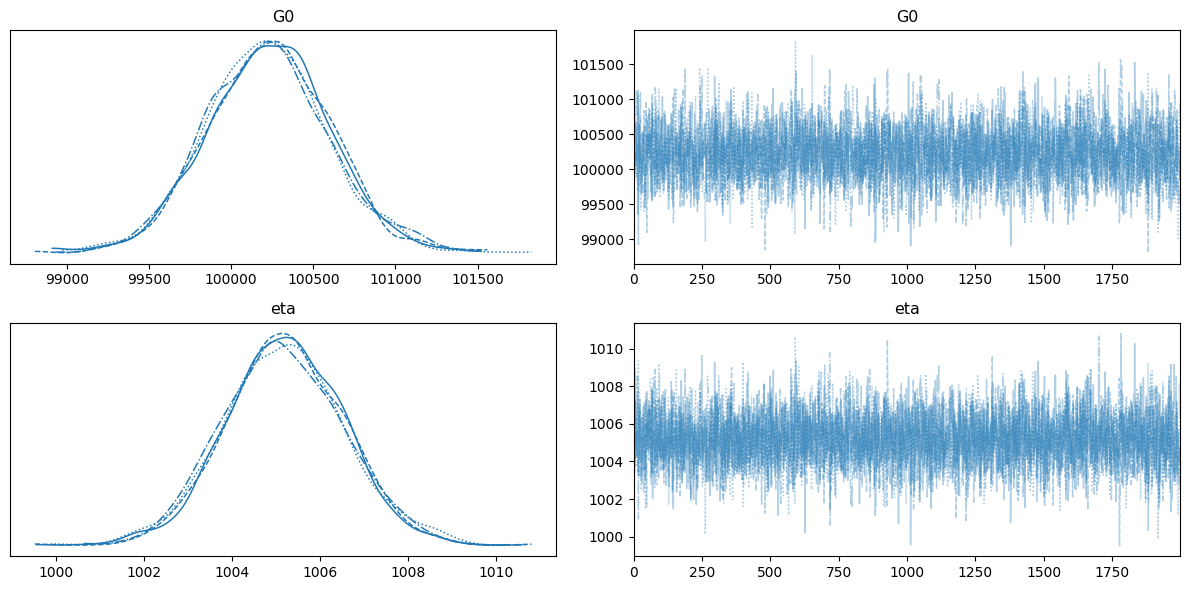

In [9]:
# Plot 1: Trace plot (convergence visual check)
print("\n  [1/6] Trace plot - Visual convergence check")
print("        • Left: Marginal posteriors (should overlap for all chains)")
print("        • Right: Parameter evolution ('fuzzy caterpillar', no trends)")
az.plot_trace(idata, var_names=['G0', 'eta'], figsize=(12, 6))
plt.tight_layout()
fig = plt.gcf()
display(fig)
plt.close(fig)


  [2/6] Rank plot - Most sensitive convergence test
        • Uniform histogram → converged
        • Non-uniform → NOT converged (increase warmup)


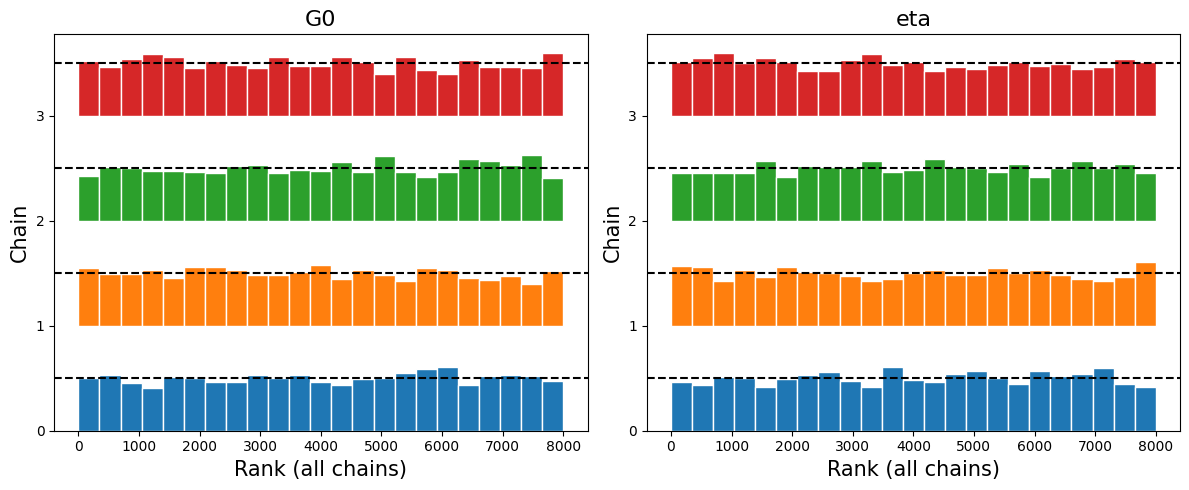

In [10]:
# Plot 2: Rank plot (most sensitive convergence diagnostic)
print("\n  [2/6] Rank plot - Most sensitive convergence test")
print("        • Uniform histogram → converged")
print("        • Non-uniform → NOT converged (increase warmup)")
az.plot_rank(idata, var_names=['G0', 'eta'], figsize=(12, 5))
plt.tight_layout()
fig = plt.gcf()
display(fig)
plt.close(fig)


  [3/6] Pair plot - Parameter correlations + divergences
        • Diagonal line → strong correlation
        • Red points → divergences (problematic regions)


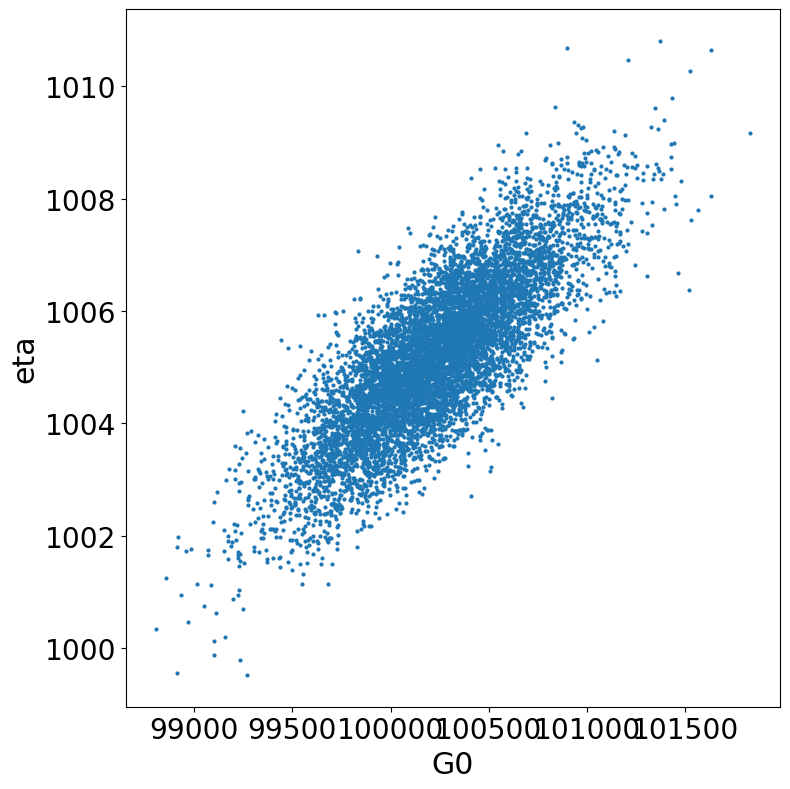

        ✓ Correlation(G₀, η) = 0.809


In [11]:
# Plot 3: Pair plot (correlations and divergences)
print("\n  [3/6] Pair plot - Parameter correlations + divergences")
print("        • Diagonal line → strong correlation")
print("        • Red points → divergences (problematic regions)")
correlation = np.corrcoef(posterior['G0'], posterior['eta'])[0, 1]
az.plot_pair(
    idata,
    var_names=['G0', 'eta'],
    kind='scatter',
    divergences=True,
    figsize=(8, 8)
)
plt.tight_layout()
fig = plt.gcf()
display(fig)
plt.close(fig)
print(f"        ✓ Correlation(G₀, η) = {correlation:.3f}")


  [4/6] Autocorrelation plot - Mixing quality
        • Fast decay to ~0 → good mixing
        • Slow decay → high autocorrelation (increase samples)


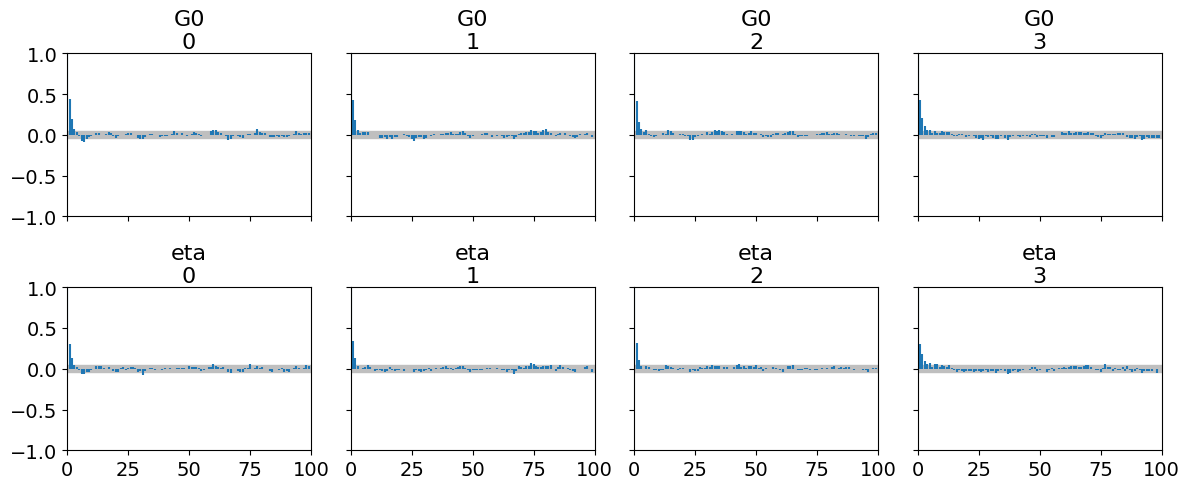

In [12]:
# Plot 4: Autocorrelation plot (mixing quality)
print("\n  [4/6] Autocorrelation plot - Mixing quality")
print("        • Fast decay to ~0 → good mixing")
print("        • Slow decay → high autocorrelation (increase samples)")
az.plot_autocorr(idata, var_names=['G0', 'eta'], max_lag=100, figsize=(12, 5))
plt.tight_layout()
fig = plt.gcf()
display(fig)
plt.close(fig)


  [5/6] ESS plot - Sampling efficiency per parameter
        • ESS > 400 → sufficient
        • ESS < 400 → increase samples


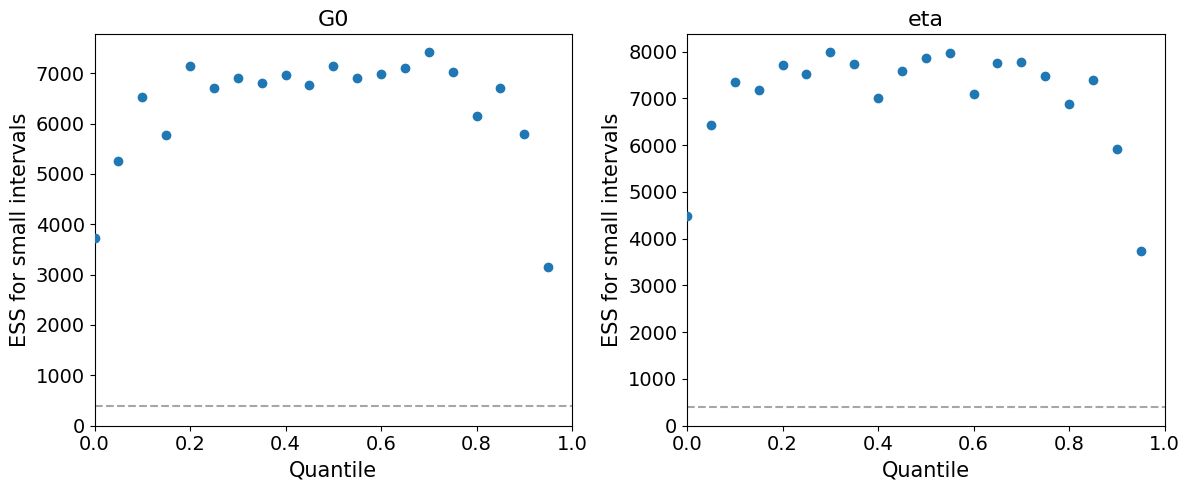

In [13]:
# Plot 5: ESS plot (sampling efficiency)
print("\n  [5/6] ESS plot - Sampling efficiency per parameter")
print("        • ESS > 400 → sufficient")
print("        • ESS < 400 → increase samples")
az.plot_ess(idata, var_names=['G0', 'eta'], kind='local', figsize=(12, 5))
plt.tight_layout()
fig = plt.gcf()
display(fig)
plt.close(fig)


  [6/6] Forest plot - Credible interval comparison
        • Quick visual of parameter magnitudes and uncertainties


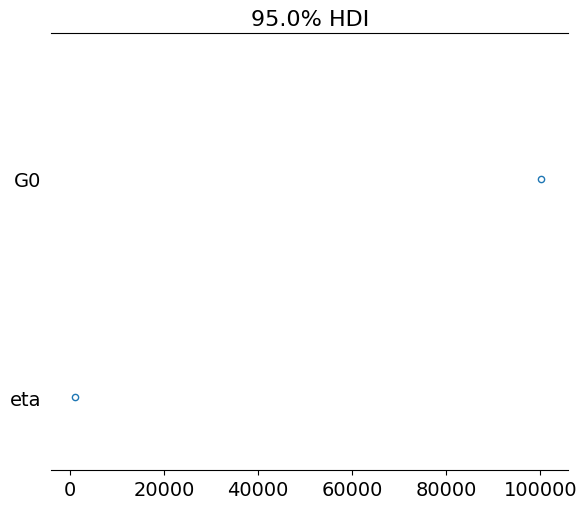

In [14]:
# Plot 6: Forest plot (credible intervals)
print("\n  [6/6] Forest plot - Credible interval comparison")
print("        • Quick visual of parameter magnitudes and uncertainties")
az.plot_forest(idata, var_names=['G0', 'eta'], combined=True, hdi_prob=0.95)
plt.tight_layout()
fig = plt.gcf()
display(fig)
plt.close(fig)

## Workflow Summary

Recap of the complete 3-stage workflow and key results.

In [15]:
print("\n" + "="*70)
print("WORKFLOW SUMMARY")
print("="*70)

print("\n✓ Completed 3-stage Bayesian workflow:")
print(f"  [1] NLSQ point estimation:      {nlsq_time:.2f}s")
print(f"  [2] NUTS posterior sampling:     {bayes_time:.1f}s (warm-start)")
print(f"  [3] ArviZ diagnostic plots:      6 plots generated")

print(f"\n✓ Convergence assessment:")
if all_converged:
    print("  • All parameters converged (R-hat < 1.01, ESS > 400)")
    print("  • Results are reliable and can be interpreted")
else:
    print("  • ⚠ Convergence issues detected")
    print("  • Increase num_warmup or num_samples and rerun")

print(f"\n✓ Uncertainty quantification:")
print(f"  • G₀ uncertainty: ±{summary['G0']['std']/summary['G0']['mean']*100:.1f}%")
print(f"  • η uncertainty:  ±{summary['eta']['std']/summary['eta']['mean']*100:.1f}%")


WORKFLOW SUMMARY

✓ Completed 3-stage Bayesian workflow:
  [1] NLSQ point estimation:      1.73s
  [2] NUTS posterior sampling:     13.8s (warm-start)
  [3] ArviZ diagnostic plots:      6 plots generated

✓ Convergence assessment:
  • All parameters converged (R-hat < 1.01, ESS > 400)
  • Results are reliable and can be interpreted

✓ Uncertainty quantification:
  • G₀ uncertainty: ±0.4%
  • η uncertainty:  ±0.1%


## Next Steps

1. Apply this workflow to your own rheological data
2. Try different models (20 models available)
3. Explore tutorial notebooks in `examples/bayesian/`:
   - `01-bayesian-basics.ipynb` (40 min)
   - `02-prior-selection.ipynb` (35 min)
   - `03-convergence-diagnostics.ipynb` (45 min)
   - `04-model-comparison.ipynb` (40 min)
   - `05-uncertainty-propagation.ipynb` (45 min)

4. Read documentation:
   - `docs/BAYESIAN_QUICK_START.md`
   - `docs/BAYESIAN_WORKFLOW_SUMMARY.md`

**For questions or issues:**
- GitHub: https://github.com/imewei/rheojax
- Docs: https://rheojax.readthedocs.io